In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2

Parameters

In [14]:
BATCH_SIZE = 48
image_size = 224
image_height = 224
EPOCHS = 5

Image Augmentation

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.95, 1.05],
    fill_mode='nearest'
)

data_generator_3 = ImageDataGenerator(rescale=1./255)

raw_generator = train_datagen.flow_from_directory(
    directory='./dataset/chest_xray/train',
    color_mode='rgb',
    target_size=(image_height, image_size),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

Found 5216 images belonging to 2 classes.


In [16]:
dict_class = raw_generator.class_indices
class_names = list(dict_class.keys())
y_classes = raw_generator.classes

Class weight addresses class imbalance in the dataset during training.

Weights are used to adjust the contribution of each class to the overall loss function and gradient calculation during backpropagation.

By assigning higher weights to the minority class and lower weights to the majority class, the model gives more importance to correctly classifying instances from the minority class.

In [17]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_classes),
                                     y=y_classes)
class_weights = dict(zip(np.unique(y_classes), class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


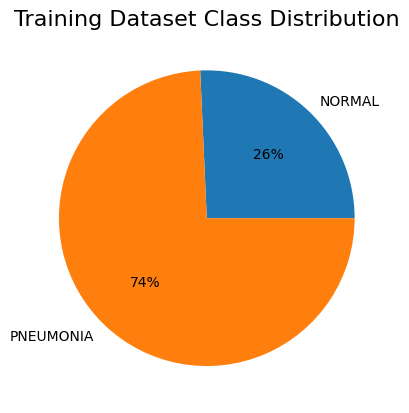

In [18]:
freq = np.unique(y_classes, return_counts=True)
plt.title('Training Dataset Class Distribution', fontsize=16)
plt.pie(freq[1], labels=class_names, autopct='%1.0f%%')
plt.show()

In [19]:
print('Train Dataset:')
print('Number of images:', len(y_classes))
print('Number of normal images:', np.sum(y_classes == 0))
print('Number of pneumonia images:', np.sum(y_classes == 1))

Train Dataset:
Number of images: 5216
Number of normal images: 1341
Number of pneumonia images: 3875


In [20]:
test_generator = data_generator_3.flow_from_directory(
    directory='./dataset/chest_xray/test',
    color_mode='rgb',
    target_size=(image_height, image_size),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42
)

Found 622 images belonging to 2 classes.


In [21]:
print('Test Dataset:')
print('Number of images:', len(test_generator.classes))
print('Number of normal images:', np.sum(test_generator.classes == 0))
print('Number of pneumonia images:', np.sum(test_generator.classes == 1))

Test Dataset:
Number of images: 622
Number of normal images: 232
Number of pneumonia images: 390


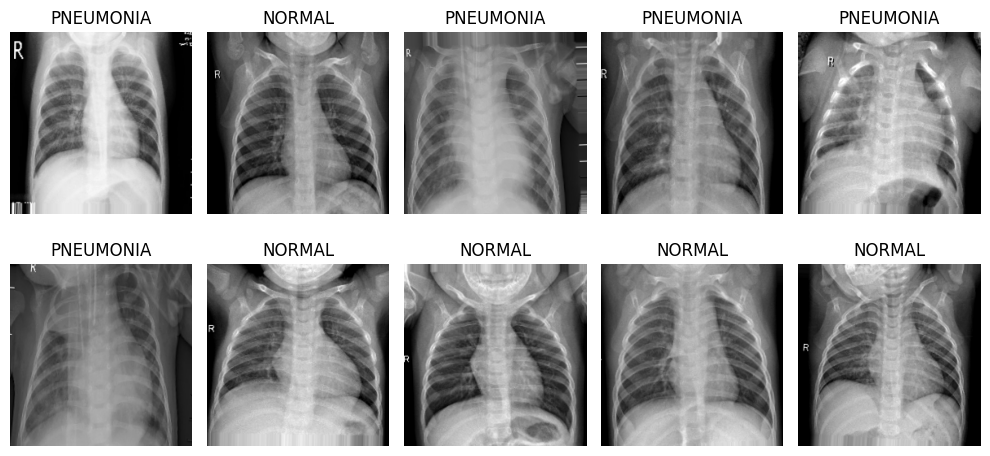

In [22]:
images, labels = next(raw_generator)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(labels[i])])
plt.tight_layout()
plt.show()

MobileNetV2 uses depthwise seperable convolutions to reduce the number of parameters and computations.

Offers good balance between accuracy and computational efficiency.

In [23]:
with tf.device('/GPU:0'):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5)

    steps_per_epoch = raw_generator.samples // BATCH_SIZE
    validation_steps = test_generator.samples // BATCH_SIZE

    history = model.fit(raw_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=EPOCHS,
          validation_data=test_generator,
          validation_steps=validation_steps,
          callbacks=[early_stop, reduce_lr])

model_MobileNetV2 = model

2025-04-24 16:15:15.260707: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 16:15:15.427292: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 16:15:15.427482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 16:15:15.442980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 16:15:15.443042: I external/local_xla/xla/stream_executor

Epoch 1/5


2025-04-24 16:15:22.353423: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-04-24 16:15:27.106149: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa685192260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-24 16:15:27.106186: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-04-24 16:15:27.313961: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745500527.676743   95463 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 [==============================] - 166s 1s/step - loss: 0.5443 - accuracy: 0.8750 - val_loss: 0.6288 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 2/5
108/108 [==============================] - 99s 919ms/step - loss: 0.3164 - accuracy: 0.9483 - val_loss: 0.4188 - val_accuracy: 0.8837 - lr: 0.0010
Epoch 3/5
108/108 [==============================] - 104s 957ms/step - loss: 0.2681 - accuracy: 0.9524 - val_loss: 0.4526 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 4/5
108/108 [==============================] - 100s 927ms/step - loss: 0.2369 - accuracy: 0.9592 - val_loss: 0.3944 - val_accuracy: 0.8819 - lr: 0.0010


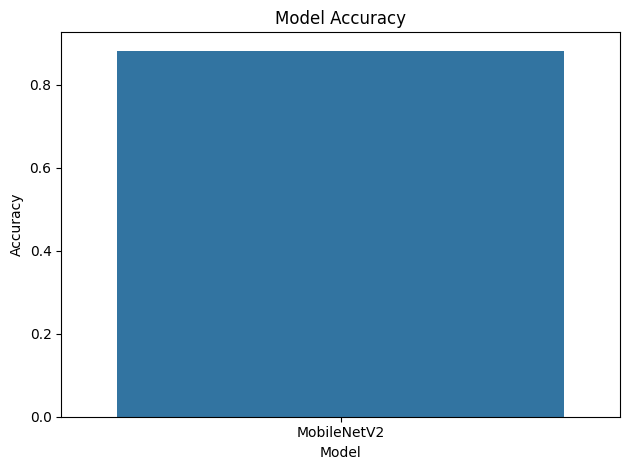

In [24]:
val_accuracy_MobileNet = history.history['val_accuracy'][-1]
data = {'MobileNetV2': val_accuracy_MobileNet}
df = pd.DataFrame.from_dict(data, orient='index', columns=['Accuracy']).reset_index().rename(columns={'index': 'Model'})
sns.barplot(x='Model', y='Accuracy', data=df)
plt.title('Model Accuracy')
plt.tight_layout()
plt.show()

In [25]:
no_base_layers = len(model_MobileNetV2.layers)
no_finetune_layers = int(no_base_layers / 2)

print(f'No. of base layers in the model = {no_base_layers}')
print(f'No. of layers for fine-tune = {no_finetune_layers}')

model_MobileNetV2.trainable = True
for layer in model_MobileNetV2.layers[:-no_finetune_layers]:
    layer.trainable = False

model_MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

history_finetune_MobileNetV2 = model_MobileNetV2.fit(
    raw_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[early_stop]
)


val_loss_finetune, val_accuracy_finetune = model_MobileNetV2.evaluate(test_generator, steps=len(test_generator))
print(f"Validation Loss after Fine-tuning: {val_loss_finetune:.4f}")
print(f"Validation Accuracy after Fine-tuning: {val_accuracy_finetune:.4f}")

No. of base layers in the model = 7
No. of layers for fine-tune = 3
Epoch 1/5
109/109 [==============================] - 105s 941ms/step - loss: 0.3091 - accuracy: 0.9396 - val_loss: 0.4095 - val_accuracy: 0.8875
Epoch 2/5
109/109 [==============================] - 100s 915ms/step - loss: 0.2991 - accuracy: 0.9473 - val_loss: 0.4126 - val_accuracy: 0.8875
Epoch 3/5
13/13 [==============================] - 7s 513ms/step - loss: 0.4095 - accuracy: 0.8875
Validation Loss after Fine-tuning: 0.4095
Validation Accuracy after Fine-tuning: 0.8875


In [26]:
test_generator.reset()
img_batch, label_batch = next(iter(test_generator))

predictions = model_MobileNetV2.predict(img_batch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(label_batch, axis=1)

2/2 [==============================] - 1s 375ms/step


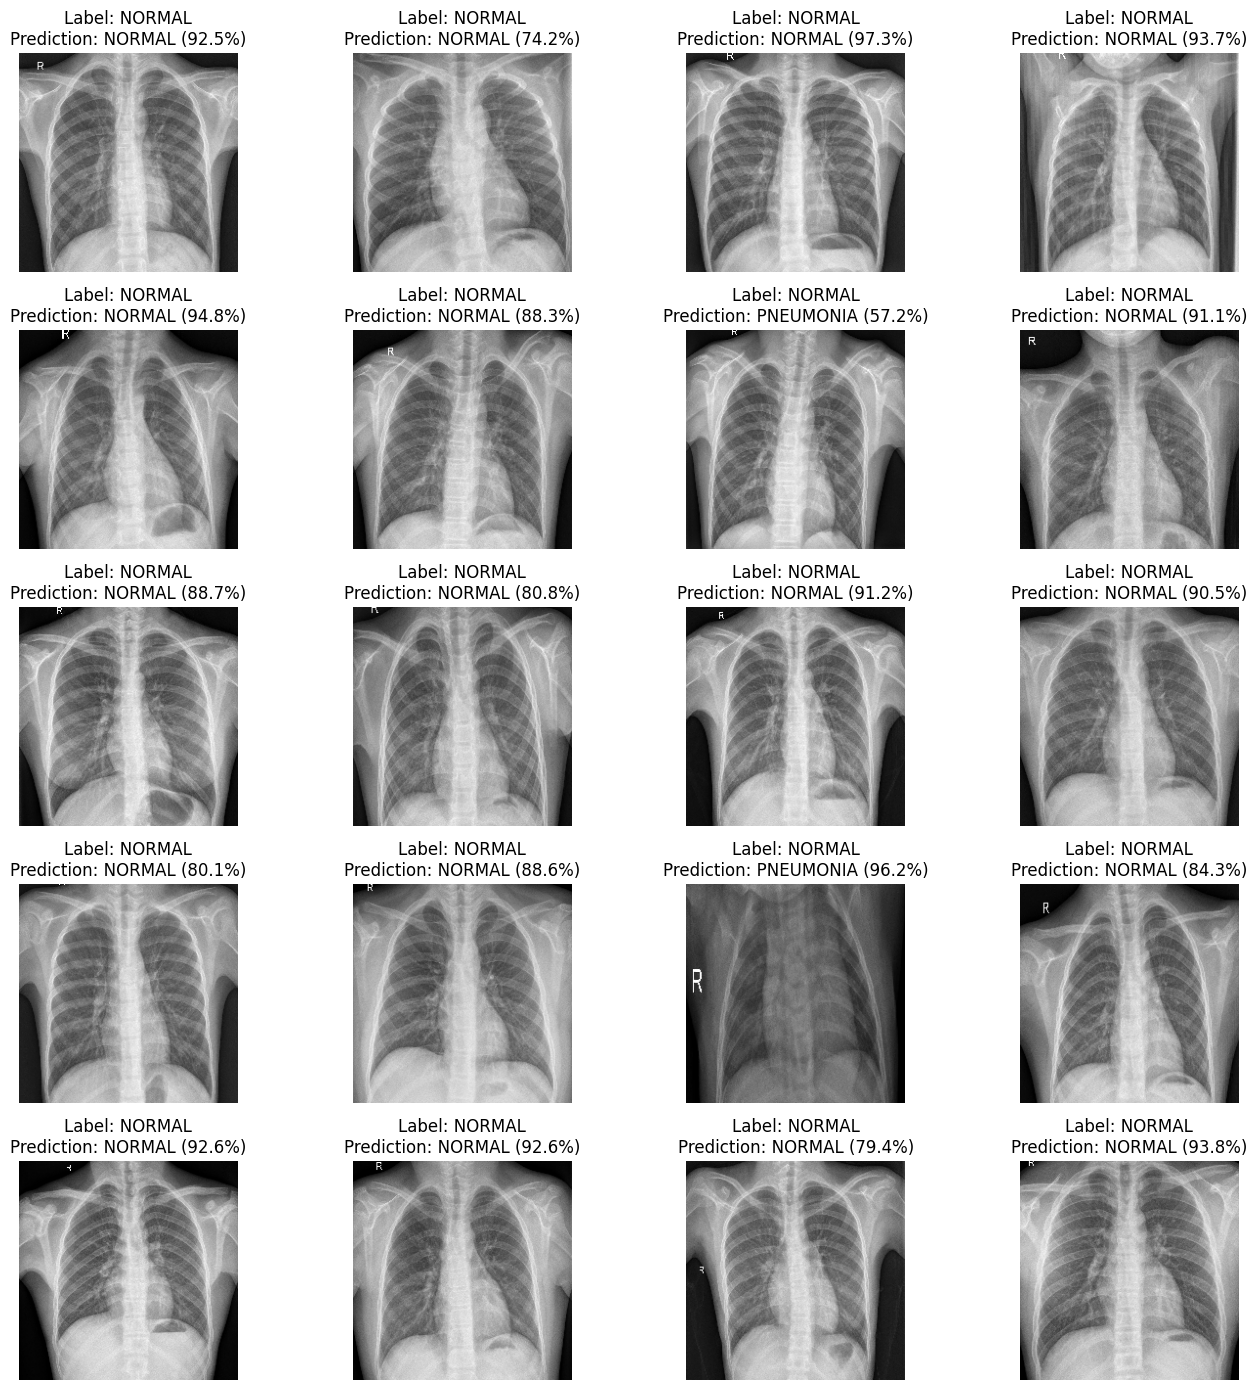

In [27]:
plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img_batch[i])
    plt.axis('off')
    true_label = class_names[true_classes[i]]
    predicted_label = class_names[predicted_classes[i]]
    confidence = 100 * np.max(predictions[i])
    plt.title(f"Label: {true_label}\nPrediction: {predicted_label} ({confidence:.1f}%)")
plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Test setini sıfırla ve tahminleri al
test_generator.reset()
pred_probs = model_MobileNetV2.predict(test_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

# Sınıf isimleri
class_names = list(test_generator.class_indices.keys())


13/13 [==============================] - 7s 508ms/step


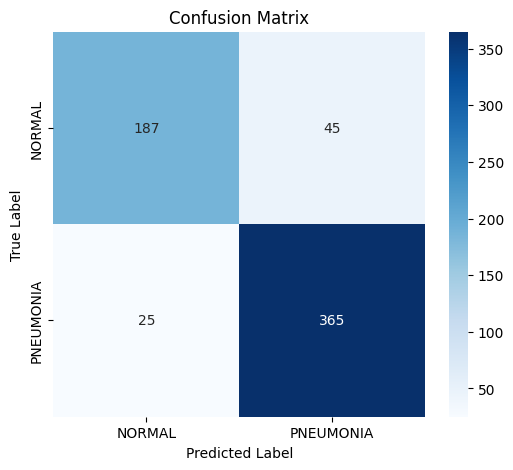

In [30]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [31]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.88      0.81      0.84       232
   PNEUMONIA       0.89      0.94      0.91       390

    accuracy                           0.89       622
   macro avg       0.89      0.87      0.88       622
weighted avg       0.89      0.89      0.89       622



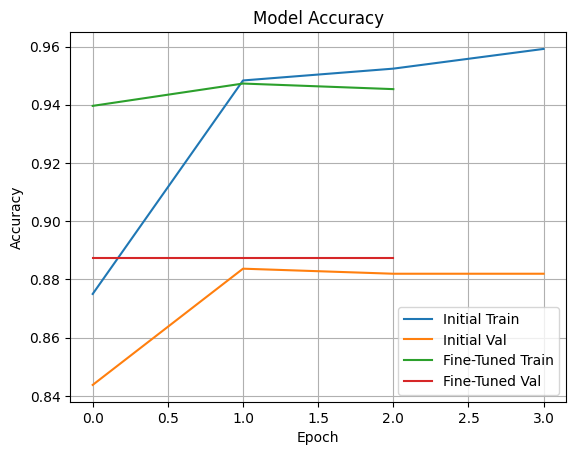

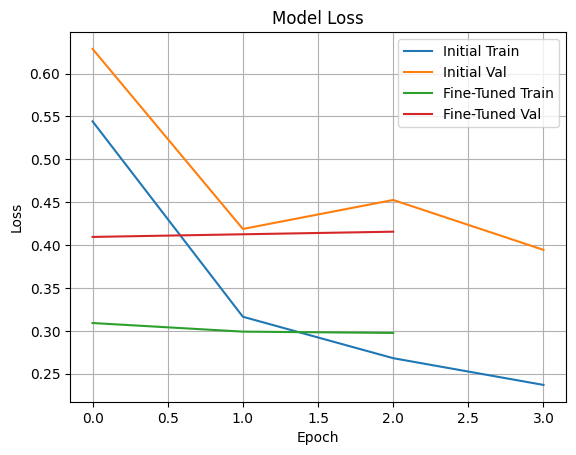

In [32]:
def plot_training_history(histories, labels):
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['accuracy'], label=f'{label} Train')
        plt.plot(hist.history['val_accuracy'], label=f'{label} Val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    for hist, label in zip(histories, labels):
        plt.plot(hist.history['loss'], label=f'{label} Train')
        plt.plot(hist.history['val_loss'], label=f'{label} Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(
    [history, history_finetune_MobileNetV2],
    labels=['Initial', 'Fine-Tuned']
)


13/13 [==============================] - 6s 432ms/step


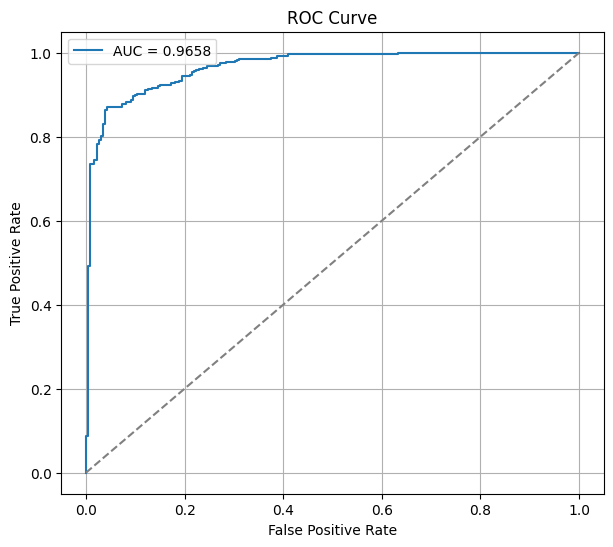

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve

y_prob = model_MobileNetV2.predict(test_generator, verbose=1)[:, 1]  # 1 = PNEUMONIA
y_true = test_generator.classes

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
model_MobileNetV2.save('pneumonia_model.keras')